# Variational Quantum Classifier

## Contents

1. [Introduction](#intro)    
    1.1  [Data Pre-Processing](#pre-process)
2. [Classification on a Quantum Computer](#vqc)    
    2.1 [Loading Data onto the Quantum Computer](#feature-maps)    
    2.2 [Building the Circuit that Classifies](#var-forms)     
    2.3 [Classical optimization loop](#classical-optimization)    
    2.4 [Boolean Map](#validate)    
    2.5 [Classifying Digits 0 and 1](#full)
3. [Testing the participant submission - Grading](#grading) 

## 1. Introduction <a id="intro"></a>

### 1.2 Data Pre-Processing <a id="pre-process"></a>

Similar to classical machine learning we employ various pre-processing techniques on the classical dataset before its fed into the quantum computer. This helps us work with larger and more complex datasets with the quantum computers we have today. The dataset we're going to work with today will be a subset of the popular handwritten digits dataset, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset. You can read more about it [here](https://en.wikipedia.org/wiki/MNIST_database).

Lets start by importing the dataset which one can download [here](http://yann.lecun.com/exdb/mnist/).

In [6]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

image_size = 28 # width and length
no_of_different_labels = 10 #  i.e. 0, 1, 2, 3, ..., 9
image_pixels = image_size * image_size
data_path = "../dataset/"
train_data = np.loadtxt(data_path + "mnist_train.csv", 
                        delimiter=",")
test_data = np.loadtxt(data_path + "mnist_test.csv", 
                       delimiter=",") 

In [19]:
print("Shape of the training dataset: {}".format(train_data.shape))
print("Shape of the testing dataset: {}".format(test_data.shape))

Shape of the training dataset: (60000, 785)
Shape of the testing dataset: (10000, 785)


Before we move forward lets take a closer look at the structure of the training dataset:

* Total of **60,000 datapoints** (rows in the matrix) corresponding to digits ranging from `0` to `9`
* The first column has the label of the datapoint ranging from `0` to `9`
* The next 784 columns/features are each a 28 $\times$ 28 grayscale image collapsed into a row. Therefore, the **dimension of the data is 784**. Each of these values range from 0 to 275 where **0 corresponds to white** and **255 corresponds to black**

Here's an example of a datapoint with label `0`. 

In [16]:
img = train_zeros[2].reshape((28, 28))
plt.imshow(img, cmap="Greys")
plt.show()

ValueError: cannot reshape array of size 785 into shape (28,28)

As we will learn in the next section, dimension of the data is equal to the number of qubits we require to encode the data using the encoding schemes we will use. Thus, encoding data with dimension 784 is not possible on quantum computers or simulators we have access to. Hence, we resort to **classically dimensionality reduction techniques**. Precisely, we apply truncated SVD and t-SNE methods from sklearn successively to reduce the dimension down to 2 for the sake of this example. Knowledge of SVD and t-SNE is not required going forwards and these reduction methods are given only for your reference. 

As the number of training and testing samples we require will be very less, we only work with the training dataset going forward and extract training, testing and validation datasets from it when required. As t-SNE is computationally expensive we will only apply it on the first 10,000 datapoints.

In [25]:
# Extracting the features and labels from the dataset and shortening the dataset to 10,000 datapoints
train_data_features = train_data[:10000, 1:]
train_data_labels = train_data[:10000, :1].reshape(10000,)

In [26]:
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

# Using SVD to bring down the dimension to 10
tsvd = TruncatedSVD(n_components=10)
X_SVD = tsvd.fit_transform(train_data_features)

# Further using t-SNE to bring the dimension down to 2
np.random.seed(0)
tsne = TSNE(n_components=2)
train_data_features_reduced = tsne.fit_transform(X_SVD)

In [27]:
print("Dimension of the reduced dataset: {}".format(train_data_features_reduced.shape[1]))

Dimension of the reduced dataset: 2


Lets plot out the dataset to see if the labels are interpretable, i.e show some sort of clustering in the reduced dataset.

In [28]:
import seaborn as sns
import pandas as pd

def plot2d(X, Y, c1, c2, N):
    lbl1 = f'Component {c1}'
    lbl2 = f'Component {c2}'    
    df = pd.DataFrame({lbl1:X[:N,c1], lbl2:X[:N,c2], 'label':Y[:N]})
    sns.lmplot(data=df, x=lbl1, y=lbl2, fit_reg=False, hue='label', scatter_kws={'alpha':0.5})   

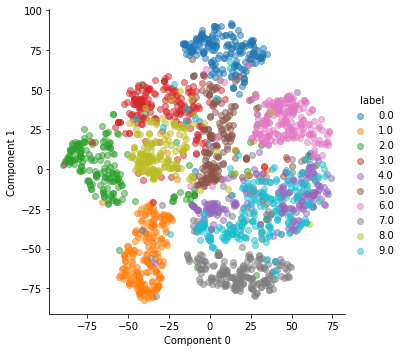

In [29]:
plot2d(train_data_features_reduced, train_data_labels, 0, 1, N=2000)

As we can see, datapoints corresponding to labels such as `0` and `1` are well separated, however, ambiguous datapoints such as those corresponding to `4` and `9` are overlapping.

Though there are methods to convert SVMs into multiclass classifiers they are inherently binary classifiers. Thus, we will start by extracting datapoints corresponsing to the digits `0` and `1` from the reduced dataset and normalize them to be between 0 and 2.  **Doubt: This is working, but usually what is the noramlisation range used?**

In [30]:
zero_datapoints = []
one_datapoints = []
for i in range(10000):
    if train_data_labels[i] == 0:
        zero_datapoints.append(train_data_features_reduced[i])

for i in range(10000):
    if train_data_labels[i] == 1:
        one_datapoints.append(train_data_features_reduced[i])
        
zero_datapoints = np.array(zero_datapoints)
one_datapoints = np.array(one_datapoints)

def normalise(arr, max_val, n):
    a = np.divide(arr, max_val)
    return a + n

zero_datapoints_normalized = normalise(zero_datapoints, 100, 1)
one_datapoints_normalized = normalise(one_datapoints, 100, 1)

## 2. Classification on a Quantum Computer <a id="vqc"></a>

There are multiple methods for classifying using a quantum computer, however, today we will concentrate on a method called the **Variational Quantum Classifier (VQC)** as proposed in the paper [Havlicek et.al](https://arxiv.org/abs/1804.11326) [1] (and as the **explicit method** in the paper [Maria Schuld et. al.](https://arxiv.org/abs/1803.07128)) [2] -> Should we include this?.

Similar to classical machine learning the VQC algorithm has a **training stage** (where datapoints with labels are provided and learning takes place) and a **testing stage** (where new datapoints without labels are provided which are then classified). Each of these stages is majorly a four step process: 

* Encoding using the quantum feature map
* Variational optimization 
* Measurement
* Assign the binary label

![vqc](./images/vqc.png)

### 2.1 Loading Data onto the Quantum Computer <a id="feature-maps"></a>

Note: This section has been adapted from [here](https://github.com/qiskit-community/qiskit-community-tutorials/blob/master/machine_learning/custom_feature_map.ipynb).

The idea of quantum feature maps comes from the theory of kernels in classical machine learning where a dataset is mapped non-linearly onto a higher dimensional space where a hyperplane can be found that classifies it. 

As the name suggests, a **quantum feature map $\phi(\vec{x})$** is a map from the classical feature vector $\vec{x}$ to the quantum state $|\Phi(\vec{x})\rangle\langle\Phi(\vec{x})|$, a vector in Hilbert space. This is faciliated by applying the unitary operation $\mathcal{U}_{\Phi(\vec{x})}$ on the initial state $|0\rangle^{n}$ where _n_ is the number of qubits being used for encoding. By doing this process we have now blown up the dimension of our feature space and task of our classifier is to find a separating hyperlane in this new space.

Constructing feature maps based on quantum circuits that are hard to simulate classically is an important step towards obtaining a quantum advantage over classical approaches. The authors of [1] proposed a family of feature maps that is conjectured to be hard to simulate classically and that can be implemented as short-depth circuits on near-term quantum devices. The quantum feature map of depth $d$ is implemented by the unitary operator 

$$ \mathcal{U}_{\Phi(\mathbf{x})}=\prod_d U_{\Phi(\mathbf{x})}H^{\otimes n},\ U_{\Phi(\mathbf{x})}=\exp\left(i\sum_{S\subseteq[n]}\phi_S(\mathbf{x})\prod_{k\in S} P_k\right), $$

which contains layers of Hadamard gates interleaved with entangling blocks encoding the classical data as shown in circuit diagram below for $d=2$.

<img src="images/uphi.PNG" width="400" />

The number of qubits $n$ in the quantum circuit is equal to the dimensionality of the classical data $\mathbf{x}$, which are encoded through the coefficients $\phi_S(\mathbf{x})$, where $S \subseteq[n] = \{1, \ldots, n \}$. We call the $r$-th order expansion the feature map of this circuit family when $|S|\leq r$. In Terra, the default is the second order expansion $|S|\leq 2$ used in [1], which gives $n$ singeltons $S=\{i\}$ and, depending on the connectivity graph of the quantum device, up to $\frac{n(n-1)}{2}$ couples to encode non-linear interactions. The greater the upper bound $r$, the more interactions will be taken into account.

Only contributions from $Z$ and $ZZ$ gates in the entangling blocks are considered in [1]. In general, the blocks can be expressed in terms of the Pauli gates $P_k \in \{\mathbb{1}_k, X_k, Y_k, Z_k \}$.

In the Terra circuit library, the circuit depth $d$, coefficients $\phi_S$, expansion order $r$, and gates $P_k$ are mutable for Variational Quantum Classifier. As discussed in [1], the depth $d=1$ circuit can be efficiently simulated classically by uniform sampling, while the $d=2$ variant is conjectured to be hard to simulate classically.

### Using Feature Maps from the Terra Circuit Library

We will now see how to configure quantum feature maps in Terra by modifing the `circuit depth` $d$, `data map function` $\phi_S$, `expansion order` $r$, and gates $P_k$. Documentation on the quantum feature maps in Terra can be found at https://qiskit.org/documentation/apidoc/circuit_library.html. 

We'll see how to build quantum feature maps inbuilt in Qiskit and a method to build your own custom feature map. Qiskit Terra's circuit library has numerous variational circuits one could use for building their quantum feature map. However, the circuits specific to the data preparation step based on paper [[1]](https://arxiv.org/abs/1804.11326) are : 

* ZFeatureMap
* ZZFeatureMap
* PauliFeatureMap

Lets start by importing the required components from Qiskit.

In [31]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import BasicAer

from qiskit import *
import numpy as np
from qiskit.visualization import plot_bloch_multivector, plot_histogram

import time
from qiskit.circuit.library import ZZFeatureMap, ZFeatureMap, PauliFeatureMap
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import VQC

### ZFeatureMap

A first order diagonal expansion is implemented using the `ZFeatureMap` feature map where $|S|=1$. The resulting circuit contains no interactions between features of the encoded data, and therefore no entanglement. The feature map can take the following inputs:

- `feature_dimension`: dimensionality of the classical data (equal to the number of required qubits)
- `reps`: number of times $d$ to repeat the feature map circuit 
- `data_map_func`: function $\phi_S(\mathbf{x})$ encoding the classical data.

The default setting `data_map_func = self_product` for the `ZFeatureMap` has $S = \{i\}$ and is given by 

$$\phi_S:x\mapsto x_i.$$

In [32]:
feature_dim = 3 

Z_feature_map = ZFeatureMap(feature_dimension=feature_dim, reps=4)
Z_feature_map.draw()

┌───┐┌──────────────┐┌───┐┌──────────────┐┌───┐┌──────────────┐┌───┐»
q_0: ┤ H ├┤ U1(2.0*x[0]) ├┤ H ├┤ U1(2.0*x[0]) ├┤ H ├┤ U1(2.0*x[0]) ├┤ H ├»
     ├───┤├──────────────┤├───┤├──────────────┤├───┤├──────────────┤├───┤»
q_1: ┤ H ├┤ U1(2.0*x[1]) ├┤ H ├┤ U1(2.0*x[1]) ├┤ H ├┤ U1(2.0*x[1]) ├┤ H ├»
     ├───┤├──────────────┤├───┤├──────────────┤├───┤├──────────────┤├───┤»
q_2: ┤ H ├┤ U1(2.0*x[2]) ├┤ H ├┤ U1(2.0*x[2]) ├┤ H ├┤ U1(2.0*x[2]) ├┤ H ├»
     └───┘└──────────────┘└───┘└──────────────┘└───┘└──────────────┘└───┘»
«     ┌──────────────┐
«q_0: ┤ U1(2.0*x[0]) ├
«     ├──────────────┤
«q_1: ┤ U1(2.0*x[1]) ├
«     ├──────────────┤
«q_2: ┤ U1(2.0*x[2]) ├
«     └──────────────┘

In [33]:
print("parameters of the Z Feature Map are: {}".format(Z_feature_map.parameters))

parameters of the Z Feature Map are: {Parameter(x[1]), Parameter(x[0]), Parameter(x[2])}


On changing the `feature_dim`  on the `ZFeatureMap` we realize that for encoding data of dimension _d_ we require _d_ qubits. And this brings us to the reason why we applied dimension reduction techniques in the classical pre-processing step. Initially the data was of dimension 784 implying that we would require 784 qubits to encode it! Post the reduction, we would only require 2 qubits. 

The parameters $x[0], x[1]$ and $x[2]$ will be filled in with the feature values of our feature vector $\vec{x}$. Thus, though we are using a variational form to construct the feature map, per input of data they are immutable circuits. Unlike variational circuits used in the variational optimization step.

### ZZFeatureMap

The `ZZFeatureMap` feature map allows $|S|\leq 2$, so interactions in the data will be encoded in the feature map according to the connectivity graph and the classical data map. `ZZFeatureMap` with default parameters is equivalent to the feature map described in [1] and can take the additional inputs:

- `entangler_map`: encodes qubit connectivity (default `None` uses a precomputed connectivity graph according to `entanglement`) 
- `entanglement`: generates connectivity `'full'` or `'linear'` if `entangler_map` not provided (default value `'full'` indicates a complete connectivity graph of $\frac{n(n-1)}{2}$ interactions)

The default setting for `data_map_func` in `ZZFeatureMap` is given by

$$\phi_S:x\mapsto \Bigg\{\begin{array}{ll}
    x_i & \mbox{if}\ S=\{i\} \\
        (\pi-x_i)(\pi-x_j) & \mbox{if}\ S=\{i,j\}
    \end{array}$$.

In [34]:
feature_dim = 2

ZZ_feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2, insert_barriers=True)
ZZ_feature_map.draw()

┌───┐┌──────────────┐     »
q_0: ┤ H ├┤ U1(2.0*x[0]) ├──■──»
     ├───┤├──────────────┤┌─┴─┐»
q_1: ┤ H ├┤ U1(2.0*x[1]) ├┤ X ├»
     └───┘└──────────────┘└───┘»
«                                                                         ┌───┐»
«q_0: ─────────────────────────────────────────────────────────────────■──┤ H ├»
«     ┌─────────────────────────────────────────────────────────────┐┌─┴─┐├───┤»
«q_1: ┤ U1(2.0*(3.14159265358979 - x[0])*(3.14159265358979 - x[1])) ├┤ X ├┤ H ├»
«     └─────────────────────────────────────────────────────────────┘└───┘└───┘»
«     ┌──────────────┐     »
«q_0: ┤ U1(2.0*x[0]) ├──■──»
«     ├──────────────┤┌─┴─┐»
«q_1: ┤ U1(2.0*x[1]) ├┤ X ├»
«     └──────────────┘└───┘»
«                                                                         
«q_0: ─────────────────────────────────────────────────────────────────■──
«     ┌─────────────────────────────────────────────────────────────┐┌─┴─┐
«q_1: ┤ U1(2.0*(3.14159265358979 - x[0])*(3.14159265358979 - x[1])) ├┤ X ├
«     └─────────────────────────────────────────────────────────────┘└───┘

In [35]:
print("parameters of the Z Feature Map are: {}".format(ZZ_feature_map.parameters))

parameters of the Z Feature Map are: {Parameter(x[1]), Parameter(x[0])}


### PauliFeatureMap

For some applications, we may want to consider a more general form of the feature map. One way to generalize is to use `PauliFeatureMap` and specify a set of Pauli gates instead of using the default $Z$ gates. This feature map has the same parameters as `ZFeatureMap` and `ZZFeatureMap` such as `reps` and `data_map_function` along with an additional `paulis` parameter to change the gate set. This parameter is a list of strings, each representing the desired Pauli gate(s). The default value is `['Z', 'ZZ']`, which is equivalent to `ZZFeatureMap`.


Each string in `paulis` is implemented one at a time for each layer in the depth $d$ feature map circuit. A single character, for example `'Z'`, adds one layer of the corresponding single-qubit gates, while terms such as `'ZZ'` or `'XY'` add a layer of corresponding two-qubit entangling gates for each qubit pair available.

For example, the choice `paulis = ['Z', 'Y', 'ZZ']` generates a quantum feature map of the form 

$$\mathcal{U}_{\Phi(\mathbf{x})} = \left( \exp\left(i\sum_{jk} \phi_{\{j,k\}}(\mathbf{x}) \, Z_j \otimes Z_k\right) \, \exp\left(i\sum_{j} \phi_{\{j\}}(\mathbf{x}) \, Y_j\right) \, \exp\left(i\sum_j \phi_{\{j\}}(\mathbf{x}) \, Z_j\right) \, H^{\otimes n} \right)^d.$$ 

The depth $d=1$ version of this quantum circuit is shown in the figure below for $n=2$ qubits.

<br>
<img src="images/depth1.PNG" width="400"/>
<br>

The circuit begins with a layer of Hadamard gates $H^{\otimes n}$ followed by a layer of single-qubit $A = e^{i\phi_{\{j\}}(\mathbf{x})Z_j}$ gates and a layer of $B = e^{i\phi_{\{j\}}(\mathbf{x}) \, Y_j}$ gates. The $A$ and $B$ gates are parametrized by the same set of angles $\phi_{\{j\}}(\mathbf{x})$ but around different axes. The diagonal entangling gate $e^{i \phi_{\{0,1\}}(\mathbf{x}) \, Z_0 \otimes Z_1}$ is parametrized by an angle $\phi_{\{0,1\}}(\mathbf{x})$ and can be implemented using two controlled-NOT gates and one $A'=e^{i\phi_{\{0,1\}}(x)\, Z_1}$ gate as shown in the figure.

As a comparison, `paulis = ['Z', 'ZZ']` creates the same circuit as above but without the $B$ gates, while `paulis = ['Z', 'YY']` creates a circuit with a layer of $A$ gates followed by a layer of entangling gates $e^{i \phi_{\{0,1\}}(\mathbf{x}) \, Y_0 \otimes Y_1}$.

Below, we test the `PauliFeatureMap` with `paulis=['Z', 'Y', 'ZZ']`.

In [36]:
feature_dim = 2

pauli_feature_map = PauliFeatureMap(feature_dimension=feature_dim, reps=1, paulis = ['Z','X','ZY'])
pauli_feature_map.draw()

┌───┐┌──────────────┐┌───┐┌──────────────┐┌───┐┌──────────┐     »
q_0: ┤ H ├┤ U1(2.0*x[0]) ├┤ H ├┤ U1(2.0*x[0]) ├┤ H ├┤ RX(pi/2) ├──■──»
     ├───┤├──────────────┤├───┤├──────────────┤├───┤└──────────┘┌─┴─┐»
q_1: ┤ H ├┤ U1(2.0*x[1]) ├┤ H ├┤ U1(2.0*x[1]) ├┤ H ├────────────┤ X ├»
     └───┘└──────────────┘└───┘└──────────────┘└───┘            └───┘»
«                                                                         »
«q_0: ─────────────────────────────────────────────────────────────────■──»
«     ┌─────────────────────────────────────────────────────────────┐┌─┴─┐»
«q_1: ┤ U1(2.0*(3.14159265358979 - x[0])*(3.14159265358979 - x[1])) ├┤ X ├»
«     └─────────────────────────────────────────────────────────────┘└───┘»
«     ┌───────────┐
«q_0: ┤ RX(-pi/2) ├
«     └───────────┘
«q_1: ─────────────
«

### 2.2 Building the Circuit that Classifies <a id="var-forms"></a>

In this step we append a short depth [Variational Circuit](https://qiskit.org/documentation/tutorials/circuits_advanced/1_advanced_circuits.html) to the previously constructed feature map. The parameters of this variational circuit are then trained in the [classical optimization loop](#classical-optimization) until it classifies the datapoints correctly. This is the learning stage of the algorithm and accuracy of the model can vary based on the variational circuit one chooses. It is essential to choose a variational circuit of shorter depth (making it especially viable for hardware implementation), lesser number of parameters to train (faster training process) while making sure its [_Expressability and Entangling capacity_](https://arxiv.org/pdf/1905.10876.pdf) are enough to classify our dataset. Defining and building "good" variational circuits is still an active field of research similar to the study of feature maps.

Coming to the implementation details, Using Terra one can build variational circuits using `NLocal` circuits or the `FunctionalPauliRotations` from the Terra circuit library documentation [here](https://qiskit.org/documentation/apidoc/circuit_library.html), [codebase](https://github.com/Qiskit/qiskit-terra/tree/master/qiskit/circuit/library).

**Constructing using [`Real Amplitudes`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RealAmplitudes.html):**

In [37]:
from qiskit.circuit.library import RealAmplitudes

num_qubits = 2

classifier_circ = RealAmplitudes(num_qubits, entanglement='full', reps=3)
classifier_circ.draw()

┌──────────┐     ┌──────────┐     ┌──────────┐     ┌──────────┐
q_0: ┤ RY(θ[0]) ├──■──┤ RY(θ[2]) ├──■──┤ RY(θ[4]) ├──■──┤ RY(θ[6]) ├
     ├──────────┤┌─┴─┐├──────────┤┌─┴─┐├──────────┤┌─┴─┐├──────────┤
q_1: ┤ RY(θ[1]) ├┤ X ├┤ RY(θ[3]) ├┤ X ├┤ RY(θ[5]) ├┤ X ├┤ RY(θ[7]) ├
     └──────────┘└───┘└──────────┘└───┘└──────────┘└───┘└──────────┘

**Constructing a Custom Variational Circuit/Feature Map:** 

In [38]:
from qiskit.circuit import QuantumCircuit, ParameterVector

num_qubits = 3
reps = 1
x = ParameterVector('x', length=num_qubits)  
custom_circ = QuantumCircuit(num_qubits)

for _ in range(reps):
    for i in range(num_qubits):
        custom_circ.rx(x[i], i)
    for i in range(num_qubits):
        for j in range(i + 1, num_qubits):
            custom_circ.cx(i, j)
            custom_circ.u1(x[i] * x[j], j)
            custom_circ.cx(i, j)
            
custom_circ.draw()

┌──────────┐                                                           »
q_0: ┤ RX(x[0]) ├──■─────────────────────■────■─────────────────────■───────»
     ├──────────┤┌─┴─┐┌───────────────┐┌─┴─┐  │                     │       »
q_1: ┤ RX(x[1]) ├┤ X ├┤ U1(x[0]*x[1]) ├┤ X ├──┼─────────────────────┼────■──»
     ├──────────┤└───┘└───────────────┘└───┘┌─┴─┐┌───────────────┐┌─┴─┐┌─┴─┐»
q_2: ┤ RX(x[2]) ├───────────────────────────┤ X ├┤ U1(x[0]*x[2]) ├┤ X ├┤ X ├»
     └──────────┘                           └───┘└───────────────┘└───┘└───┘»
«                           
«q_0: ──────────────────────
«                           
«q_1: ───────────────────■──
«     ┌───────────────┐┌─┴─┐
«q_2: ┤ U1(x[1]*x[2]) ├┤ X ├
«     └───────────────┘└───┘

We can use the same method as above to construct Custom Feature Maps as well!

### 2.3 Classical optimization loop <a id="classical-optimization"></a>

**Cost Function:**

In the Qiskit VQC implementation they seem to be implementing a cross-entropy loss function such as $H(p, q) = - \sum_{x}p(x)\log{q(x)}$ where _p_ and _q_ are two probability distributions. 

train() -> find_minimum([_cost_function_wrapper()_](https://github.com/Qiskit/qiskit-aqua/blob/b4b3e34372ddbea9bdef6655918e3fcb3017dc59/qiskit/aqua/algorithms/classifiers/vqc.py#L368)) -> [cost_estimate()](https://github.com/Qiskit/qiskit-aqua/blob/b4b3e34372ddbea9bdef6655918e3fcb3017dc59/qiskit/aqua/algorithms/classifiers/vqc.py#L663)


Whereas in the paper they used $R_{emp}(\theta)$ as the cost function 

![r_emp](./images/r_emp.png)

where 

![pr](./images/pr.png)

**Optimization methods in Aqua:**

* COBYLA - Good for noiseless situations
* SPSA - Good for noisy situations
* etc.

### 2.4 Boolean Map <a id="validate"></a>

One detail that has been left out is the fourth step in the process, i.e, After applying the variational circuit in step  post the measurement we are left with an _n_ bit classical string from whchich we must derive out classification result. This is done with the help of a boolean function $f: \{0, 1\}^{n} -> \{0, 1\}$

This function is defined in the VQC Qiskit code base as: 

![assign_label](./images/assign_label.png)

### 2.5 Classifying Digits 0 and 1 <a id="full"></a>

Lets apply what we've learnt using the **VQC method in Aqua** to solve our classifcation task of classifying digits `0` and `1`. Using 10,000 points for training using a simulator will take ages, hence we will take a very small subset of **20 training datapoints** and **10 testing datapoints**. We also keep 5 points per label as a validation set to see exactly how our model is classifying the given inputs. 

In [39]:
train_size = 20
test_size = 10
dp_size_zero = 5
dp_size_one = 5

zero_train = zero_datapoints_normalized[:train_size]
one_train = one_datapoints_normalized[:train_size]

zero_test = zero_datapoints_normalized[train_size + 1:train_size + test_size + 1]
one_test = one_datapoints_normalized[train_size + 1:train_size + test_size + 1]

training_input = {'A':zero_train, 'B':one_train}
test_input = {'A':zero_test, 'B':one_test}

datapoints = []
dp_zero = zero_datapoints_normalized[train_size + test_size + 2:train_size + test_size + 2 + dp_size_zero]
dp_one = one_datapoints_normalized[train_size + test_size + 2:train_size + test_size + 2 + dp_size_one]
datapoints.append(np.concatenate((dp_zero, dp_one)))
dp_y = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])
datapoints.append(dp_y)
# print(datapoints)
class_to_label = {'A': 0, 'B': 1}

**Instantiate the Feature map to use:**

In [40]:
seed = 10598
feature_dim = zero_train.shape[1]

feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2, entanglement='linear')
feature_map.draw()

┌───┐┌──────────────┐     »
q_0: ┤ H ├┤ U1(2.0*x[0]) ├──■──»
     ├───┤├──────────────┤┌─┴─┐»
q_1: ┤ H ├┤ U1(2.0*x[1]) ├┤ X ├»
     └───┘└──────────────┘└───┘»
«                                                                         ┌───┐»
«q_0: ─────────────────────────────────────────────────────────────────■──┤ H ├»
«     ┌─────────────────────────────────────────────────────────────┐┌─┴─┐├───┤»
«q_1: ┤ U1(2.0*(3.14159265358979 - x[0])*(3.14159265358979 - x[1])) ├┤ X ├┤ H ├»
«     └─────────────────────────────────────────────────────────────┘└───┘└───┘»
«     ┌──────────────┐     »
«q_0: ┤ U1(2.0*x[0]) ├──■──»
«     ├──────────────┤┌─┴─┐»
«q_1: ┤ U1(2.0*x[1]) ├┤ X ├»
«     └──────────────┘└───┘»
«                                                                         
«q_0: ─────────────────────────────────────────────────────────────────■──
«     ┌─────────────────────────────────────────────────────────────┐┌─┴─┐
«q_1: ┤ U1(2.0*(3.14159265358979 - x[0])*(3.14159265358979 - x[1])) ├┤ X ├
«     └─────────────────────────────────────────────────────────────┘└───┘

**Instantiate the Classical Optimizer to use:**

In [41]:
from qiskit.aqua.components.optimizers import COBYLA

cobyla = COBYLA(maxiter=500, tol=0.001)

**Instantiate the variational Circuit to use:**

In [42]:
from qiskit.circuit.library import EfficientSU2, RealAmplitudes

var = EfficientSU2(feature_dim, reps=2)
var.draw()

┌──────────┐┌──────────┐     ┌──────────┐┌──────────┐     ┌──────────┐»
q_0: ┤ RY(θ[0]) ├┤ RZ(θ[2]) ├──■──┤ RY(θ[4]) ├┤ RZ(θ[6]) ├──■──┤ RY(θ[8]) ├»
     ├──────────┤├──────────┤┌─┴─┐├──────────┤├──────────┤┌─┴─┐├──────────┤»
q_1: ┤ RY(θ[1]) ├┤ RZ(θ[3]) ├┤ X ├┤ RY(θ[5]) ├┤ RZ(θ[7]) ├┤ X ├┤ RY(θ[9]) ├»
     └──────────┘└──────────┘└───┘└──────────┘└──────────┘└───┘└──────────┘»
«     ┌───────────┐
«q_0: ┤ RZ(θ[10]) ├
«     ├───────────┤
«q_1: ┤ RZ(θ[11]) ├
«     └───────────┘

Constructing a callback function to get the parameter values after each iteration

In [43]:
def call_back_vqc(eval_count, var_params, eval_val, index):
    print("eval_count: {}".format(eval_count))
    print("var_params: {}".format(var_params))
    print("eval_val: {}".format(eval_val))
    print("index: {}".format(index))

**Bringing everything together**

In [44]:
backend = BasicAer.get_backend('qasm_simulator')
backend_options = {"method": "statevector_gpu"}
# backend = BasicAer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed, backend_options=backend_options)

vqc = VQC(optimizer=cobyla, feature_map=feature_map, var_form=var, callback=call_back_vqc, training_dataset=training_input, 
         test_dataset=test_input, datapoints=datapoints[0])

In [45]:
start = time.process_time()

result = vqc.run(quantum_instance)

print("time taken: ")
print(time.process_time() - start)


print("testing success ratio: {}".format(result['testing_accuracy']))

eval_count: 0
var_params: [ 3.30045889e-01 -4.79979434e-04  8.18115898e-01  4.28213708e-01
 -2.50394732e+00  1.20481133e-01  8.07892857e-01  6.02120978e-01
 -8.65190000e-01 -1.53320351e-01 -2.40490559e-01 -6.07633463e-02]
eval_val: 0.37760959185853665
index: 0
eval_count: 1
var_params: [ 1.33004589e+00 -4.79979434e-04  8.18115898e-01  4.28213708e-01
 -2.50394732e+00  1.20481133e-01  8.07892857e-01  6.02120978e-01
 -8.65190000e-01 -1.53320351e-01 -2.40490559e-01 -6.07633463e-02]
eval_val: 0.506613301727822
index: 1
eval_count: 2
var_params: [ 0.33004589  0.99952002  0.8181159   0.42821371 -2.50394732  0.12048113
  0.80789286  0.60212098 -0.86519    -0.15332035 -0.24049056 -0.06076335]
eval_val: 0.37760959185853665
index: 2
eval_count: 3
var_params: [ 3.30045889e-01 -4.79979434e-04  1.81811590e+00  4.28213708e-01
 -2.50394732e+00  1.20481133e-01  8.07892857e-01  6.02120978e-01
 -8.65190000e-01 -1.53320351e-01 -2.40490559e-01 -6.07633463e-02]
eval_val: 0.37760959185853665
index: 3
eval_co

eval_count: 32
var_params: [ 6.31327761e-01 -4.79979434e-04  8.18115898e-01  7.57379235e-01
 -1.10853771e+00  5.35194344e-02  1.91245798e+00  1.36199226e+00
 -1.17227680e+00 -2.92974667e-01 -2.51498802e-01 -3.07929446e-01]
eval_val: 0.22449751797948653
index: 32
eval_count: 33
var_params: [ 7.28664027e-01 -4.79979434e-04  8.18115898e-01  7.70400560e-01
 -1.15429735e+00 -6.59150934e-02  1.87398053e+00  1.51227310e+00
 -1.07360761e+00 -4.26961221e-01 -2.70380760e-01 -3.04300973e-01]
eval_val: 0.24020713150066636
index: 33
eval_count: 34
var_params: [ 6.96226993e-01 -4.79979434e-04  8.18115898e-01  7.41586303e-01
 -1.11435564e+00  1.62932563e-01  1.91999724e+00  1.45653221e+00
 -1.00667730e+00 -4.79264950e-01 -3.10604200e-01 -4.92739187e-01]
eval_val: 0.20913945758013774
index: 34
eval_count: 35
var_params: [ 6.85393797e-01 -4.79979434e-04  8.18115898e-01  7.24580149e-01
 -1.11649911e+00  2.55064645e-01  1.71214046e+00  1.40294486e+00
 -1.06004092e+00 -5.19543291e-01 -3.12275981e-01 -5.47

eval_count: 64
var_params: [ 6.60633003e-01 -4.79979434e-04  1.04213060e+00  7.01363146e-01
 -1.34987454e+00  4.20138353e-01  1.80732867e+00  1.53549513e+00
 -1.24254781e+00 -8.10203353e-01 -1.63879797e-01 -6.95786234e-01]
eval_val: 0.19534468719093012
index: 64
eval_count: 65
var_params: [ 6.68045555e-01 -4.79979434e-04  1.06216010e+00  6.96257710e-01
 -1.36197909e+00  4.28951838e-01  1.76617560e+00  1.42283681e+00
 -1.15638175e+00 -8.01239550e-01 -1.35769633e-01 -6.79148505e-01]
eval_val: 0.19319420644372245
index: 65
eval_count: 66
var_params: [ 6.67531490e-01 -4.79979434e-04  1.06865429e+00  6.80240826e-01
 -1.36695982e+00  4.38782274e-01  1.77864756e+00  1.44973614e+00
 -1.18377366e+00 -7.68044896e-01 -1.72729906e-01 -6.60043519e-01]
eval_val: 0.19145594705237143
index: 66
eval_count: 67
var_params: [ 6.57941427e-01 -4.79979434e-04  1.09105912e+00  6.59781494e-01
 -1.38143142e+00  4.56842775e-01  1.76281609e+00  1.47506023e+00
 -1.16400645e+00 -7.43206281e-01 -1.54026353e-01 -6.49

eval_count: 96
var_params: [ 6.49071470e-01 -4.79979434e-04  1.11680019e+00  6.92085947e-01
 -1.35921652e+00  4.37384439e-01  1.78319217e+00  1.41407310e+00
 -1.26533311e+00 -7.56544267e-01 -1.86253174e-01 -6.05543843e-01]
eval_val: 0.1891871445837347
index: 96
eval_count: 97
var_params: [ 6.49769218e-01 -4.79979434e-04  1.11287580e+00  7.02480714e-01
 -1.36929187e+00  4.35092886e-01  1.78723769e+00  1.41750824e+00
 -1.26187155e+00 -7.59544876e-01 -1.81233633e-01 -6.05190351e-01]
eval_val: 0.18910552640882577
index: 97
eval_count: 98
var_params: [ 6.44380114e-01 -4.79979434e-04  1.10823226e+00  6.98470925e-01
 -1.36472158e+00  4.32535146e-01  1.78453242e+00  1.42156394e+00
 -1.25815698e+00 -7.66091298e-01 -1.87167780e-01 -5.94881373e-01]
eval_val: 0.18972567151457795
index: 98
eval_count: 99
var_params: [ 6.43067572e-01 -4.79979434e-04  1.11377327e+00  6.96411606e-01
 -1.36770465e+00  4.29877297e-01  1.78853896e+00  1.41755004e+00
 -1.26337050e+00 -7.60628158e-01 -1.79105606e-01 -6.047

eval_count: 128
var_params: [ 6.30697092e-01 -2.15882778e-04  1.10599680e+00  7.07165866e-01
 -1.36742800e+00  4.42813604e-01  1.79507610e+00  1.41567830e+00
 -1.26454531e+00 -7.60292334e-01 -1.87302290e-01 -5.99677330e-01]
eval_val: 0.18886033829184043
index: 128
eval_count: 129
var_params: [ 6.28953867e-01  1.76238474e-03  1.10487163e+00  7.06311030e-01
 -1.36628577e+00  4.44765322e-01  1.79447264e+00  1.41657233e+00
 -1.26617781e+00 -7.60163766e-01 -1.87305737e-01 -6.00756868e-01]
eval_val: 0.1887462562727761
index: 129
eval_count: 130
var_params: [ 6.27821010e-01  7.53211138e-04  1.10595683e+00  7.04584113e-01
 -1.36526043e+00  4.45130609e-01  1.79520211e+00  1.41488942e+00
 -1.26418275e+00 -7.60882244e-01 -1.89273276e-01 -6.02145088e-01]
eval_val: 0.18865704074837847
index: 130
eval_count: 131
var_params: [ 6.28463830e-01  5.02342898e-04  1.10510049e+00  7.04190650e-01
 -1.36466664e+00  4.44344956e-01  1.79503464e+00  1.41547694e+00
 -1.26431861e+00 -7.60421624e-01 -1.90177691e-01

In [46]:
print("preduction of datapoints:")
print("ground truth: {}".format(map_label_to_class_name(datapoints[1], vqc.label_to_class)))
print("prediction:   {}".format(result['predicted_classes']))

preduction of datapoints:
ground truth: ['A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B']
prediction:   ['A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B']


**Extras:**    
* Are participants allowed to use softwares other than Qiskit for solving this problem? (Pennylane has [metric learning](https://pennylane.ai/qml/demos/tutorial_embeddings_metric_learning.html) using which I suppose participants could try and learn the feature map itself, Not 100% sure)
* If someone wants use something like a [QAOA embedding](https://pennylane.ai/qml/demos/tutorial_embeddings_metric_learning.html) how should they do it? (Alternating feature maps + var circuits)

## Grading

How do we get the `result` object from the attendee?

In [47]:
result

{'num_optimizer_evals': 154,
 'min_val': 0.18862653359708043,
 'opt_params': array([ 6.28333008e-01,  1.16139857e-03,  1.10607030e+00,  7.04044520e-01,
        -1.36405384e+00,  4.44446601e-01,  1.79484816e+00,  1.41435238e+00,
        -1.26423261e+00, -7.60147817e-01, -1.89743340e-01, -6.02065559e-01]),
 'eval_time': 586.760115146637,
 'eval_count': 154,
 'training_loss': 0.18862653359708043,
 'testing_accuracy': 1.0,
 'test_success_ratio': 1.0,
 'testing_loss': 0.16261911086660036,
 'predicted_probs': array([[0.88769531, 0.11230469],
        [0.92871094, 0.07128906],
        [0.81933594, 0.18066406],
        [0.72070312, 0.27929688],
        [0.86035156, 0.13964844],
        [0.05566406, 0.94433594],
        [0.08398438, 0.91601562],
        [0.09570312, 0.90429688],
        [0.08105469, 0.91894531],
        [0.03710938, 0.96289062]]),
 'predicted_labels': array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1]),
 'predicted_classes': ['A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B']}

Extracting the optimal parameters

In [73]:
optimal_params = vqc.optimal_params
optimal_params_stored=np.array([ 6.28333008e-01 , 1.16139857e-03 , 1.10607030e+00 , 7.04044520e-01,
 -1.36405384e+00 , 4.44446601e-01 , 1.79484816e+00 , 1.41435238e+00,
 -1.26423261e+00 ,-7.60147817e-01 ,-1.89743340e-01, -6.02065559e-01])
print(optimal_params)

[ 6.28333008e-01  1.16139857e-03  1.10607030e+00  7.04044520e-01
 -1.36405384e+00  4.44446601e-01  1.79484816e+00  1.41435238e+00
 -1.26423261e+00 -7.60147817e-01 -1.89743340e-01 -6.02065559e-01]


In [75]:
def grade(data, labels, feature_map, var_form, optimal_params):
    backend = BasicAer.get_backend('qasm_simulator')
    backend_options = {"method": "statevector_gpu"}
    # backend = BasicAer.get_backend('statevector_simulator')
    quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed, backend_options=backend_options)
    vqc = VQC(optimizer=cobyla, feature_map=feature_map, var_form=var_form, training_dataset=training_input)
    ans = vqc.predict(data, quantum_instance=quantum_instance, params=optimal_params)
    accuracy = np.sum(np.array(labels) == ans[1])/len(ans[1])
    return accuracy, ans

In [76]:
final_test_data = datapoints[0]
final_test_labels = datapoints[1]

In [78]:
accuracy, ans = grade(final_test_data, final_test_labels, feature_map=feature_map, var_form=var, 
                      optimal_params=optimal_params_stored)
print(ans)  
print("Accuracy of the model: {}".format(accuracy))

(array([[0.88769531, 0.11230469],
       [0.92871094, 0.07128906],
       [0.81933594, 0.18066406],
       [0.72070312, 0.27929688],
       [0.86035156, 0.13964844],
       [0.05566406, 0.94433594],
       [0.08398438, 0.91601562],
       [0.09570312, 0.90429688],
       [0.08105469, 0.91894531],
       [0.03710938, 0.96289062]]), array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1]))
Accuracy of the model: 1.0
